In [197]:
import jax.numpy as jnp
import jax
import numpy as np
from scipy.stats import qmc
from scipy.stats import lognorm, norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd

def simulation_alpha_stable_rqmc(alpha: float, beta: float, gamma: float, delta: float, n: int, seed : int = None):
    """
    Generate n samples from an alpha-stable distribution using an RQMC sequence.
    
    Parameters:
        alpha (float): Stability parameter (0 < alpha <= 2).
        beta (float): Skewness parameter (-1 <= beta <= 1).
        gamma (float): Scale parameter.
        delta (float): Location parameter.
        n (int): Number of samples to generate.
    
    Returns:
        jnp.ndarray: A vector of n samples from the specified alpha-stable distribution.
    """
    # 1. Generate a 2D Sobol sequence with scrambling (RQMC)
    sampler = qmc.Sobol(d=2, scramble=True)
    # Generate n points in [0,1]^2
    points = sampler.random(n)
    
    # 2. Transform the first coordinate to [-pi/2, pi/2] for u
    half_pi = jnp.pi / 2
    # Note: Convert the numpy array to a jax array if necessary
    u = jnp.array(points[:, 0]) * jnp.pi - half_pi
    
    # 3. Transform the second coordinate via the inverse CDF to get exponential variables
    v = jnp.array(points[:, 1])
    # Avoid issues with logarithm of zero by adding a small epsilon if needed.
    epsilon = 1e-10
    w = -jnp.log(v + epsilon)
    
    # 4. Calculate y using the Chambers–Mallows–Stuck method
    tol = 1e-6  # tolerance for checking if alpha ~ 1
    
    def branch_alpha_eq_1():
        return (2 / jnp.pi) * (
            (half_pi + beta * u) * jnp.tan(u) -
            beta * jnp.log((half_pi * w * jnp.cos(u)) / (half_pi + beta * u))
        )

    def branch_alpha_neq_1():
        S = (1 + beta**2 * jnp.tan(half_pi * alpha)**2) ** (1 / (2 * alpha))
        B = (1 / alpha) * jnp.arctan(beta * jnp.tan(half_pi * alpha))
        return S * (jnp.sin(alpha * (u + B)) / (jnp.cos(u)) ** (1/alpha)) * (
            (jnp.cos(u - alpha * (u + B))) / w
        ) ** ((1 - alpha) / alpha)

    y = jax.lax.cond(jnp.abs(alpha - 1) < tol, branch_alpha_eq_1, branch_alpha_neq_1)
    
    # 5. Apply the scale and location transformation.
    return gamma * y + delta


def prior_sample_init():
    """
    Tire 1  theta selon la loi a priori().
    Exemple: on suppose alpha ~ Uniform(0,2), beta ~ Uniform(-1,1),
             gamma ~ Lognormal(0,1), delta ~ Normal(0,5)
  
    """
  
    alpha = np.random.uniform(0.1, 2.0)   # on évite alpha < 0.1
    beta  = np.random.uniform(-1.0, 1.0)
    gamma= np.random.lognormal(mean=0.0, sigma=1.0)
    delta = np.random.normal(loc=0.0, scale=0.5)
    return np.array((alpha, beta, gamma, delta))

def g(teta):
    """
    Tire 1  theta selon la loi a priori(teta|teta i-1).
    Exemple: on suppose alpha ~ Uniform(0,2), beta ~ Uniform(-1,1),
             gamma ~ Lognormal(0,1), delta ~ Normal(0,5)
  
    """

    alpha_input, beta_input, gamma_input, delta_input=teta

    a_low  = max(0.1, alpha_input - 0.2) # on évite alpha < 0.1
    a_high = min(2.0, alpha_input + 0.2)
    alpha = np.random.uniform(a_low, a_high)  

    b_low  = max(-1.0, beta_input - 0.2)
    b_high = min( 1.0, beta_input + 0.2) 
    beta  = np.random.uniform(b_low, b_high)

    gamma = gamma_input * np.exp(np.random.normal(0., 0.1))


    delta = np.random.normal(loc=delta_input, scale=0.5)
    return np.array((alpha, beta, gamma, delta))

def simulate_xi(teta):
    alpha_input, beta_input, gamma_input, delta_input=teta

    x=simulation_alpha_stable_rqmc(alpha_input, beta_input, gamma_input, delta_input,4096  )
    return x



#--------------------------------------------------------Statistics summary start-----------------------------------


#some functions
def log_abs_phi(t,x):
    """log |Phi(t)| for a=1 and a!=1, 
    abs value of a complex exponential | exp(z)| , where z=a+ib ->> | exp(z)|= exp(real(z))=exp(a)

    +we take log so all this expression (3.1) simplifies to :

    log |Phi(t)|= - (gamma**alpha) * abs(t)**alpha for a=1 & a!=1
    but problem: we can't use it, so we use another formula of :::

    phi_t = sum(np.exp(1j * t * x)) / len(x)
    log_abs_phi_hat = np.log(abs(phi_t)) (as in s4 took in abs and log)
    
    """
    phi_t = np.mean(np.exp(1j * t * x))   
    log_abs_phi_hat = np.log(abs(phi_t))  
    return   log_abs_phi_hat

def u_hat(t, x):
    num = np.mean(np.sin(t * x))                
    denum = np.mean(np.cos(t * x))
    return np.arctan(num / denum)#typo in pdf!! as sum sin/sum cos= True!!


#s3    
def s3(x):
    t1, t2, t3, t4 = 0.2, 0.8, 0.1, 0.4
    # 1. α̂ -----------------------------------------------------------------------
    alpha_hat = np.log( 
        log_abs_phi(t1, x) / log_abs_phi(t2, x)
        
    ) / np.log(abs(t1 / t2))

    # 2. γ̂ ---------------------------------------------------------------------
    log_gamma_hat = (
        np.log(abs(t1)) * np.log(-log_abs_phi(t2, x))
        - np.log(abs(t2)) * np.log(-log_abs_phi(t1, x))
    ) / np.log(abs(t1 / t2))
    gamma_hat = np.exp(log_gamma_hat)

    # 3. β̂ -------------------------------------------------------------------------
    u_t3 = u_hat(t3, x)
    u_t4 = u_hat(t4, x)

    beta_hat = (
        u_t4 / t4 - u_t3 / t3
    ) / (
        (abs(t4) ** (alpha_hat - 1) - abs(t3) ** (alpha_hat - 1))
        * (gamma_hat ** alpha_hat)
        * np.tan(np.pi * alpha_hat / 2)
    )

    # 4. δ̂ ------------------------------------------------------------------
    delta_hat = (
        abs(t4) ** (alpha_hat - 1) * u_t3 / t3
        - abs(t3) ** (alpha_hat - 1) * u_t4 / t4
    ) / (abs(t4) ** (alpha_hat - 1) - abs(t3) ** (alpha_hat - 1))

    return np.array((alpha_hat,beta_hat,log_gamma_hat,delta_hat))
#s4    
def s4(x):
    """
    Returns concatenated real and imaginary parts.
    """
    #positive grid
    t_pos = np.arange(0.5, 5.1, 0.5)
    #make ±
    t_vals = np.concatenate([t_pos, -t_pos])
    #important to standartise! 
    new_x=(x-np.mean(x))/(np.quantile(x,0.75)-np.quantile(x,0.25))
    #compute φ̂(t) for each t in our grid
    phi = np.array([np.mean(np.exp(1j * t * new_x)) for t in t_vals])
    return np.hstack((phi.real, phi.imag))


def stat(statistic, x):
    """ 
    for mcmc abc we use S3,S4 statistic

    """
    if statistic == "s3":
        return s3(x)
    elif statistic == "s4":
        return s4(x)
    else:
        raise ValueError(f"Unknown summary statistic '{statistic}'")



def dist(s_sim, s_obs):
    """  L2 norm"""
    return np.linalg.norm(s_sim - s_obs, ord=2)
#------------------------------------------------Statistics summary end---------------------------------------------

def log_prior(teta):
    #calculate joint density of theta
    alpha_input, beta_input, gamma_input, delta_input=teta

    if not (0.1<alpha_input<2) or not (-1<beta_input<1) or  (gamma_input<=0):
        return -np.inf#force rejection
    #marginal densities:
    log_pdf_alpha=-np.log(2-0.1)
    log_pdf_beta=-np.log(2)
    log_pdf_gamma = lognorm.logpdf(gamma_input, s=0.1, scale=np.exp(0.0))#s=1 (sigma),scale=exp(mu)
    log_pdf_delta = norm.logpdf(delta_input,  loc=0.0, scale=0.5)
    #joint density=prod of marginal densities=sum of log of marginal densities
    return log_pdf_alpha+log_pdf_beta+log_pdf_gamma+log_pdf_delta

def log_uniform_pdf(point,param,lb,up):
    #calculate pdf at point "point" at parameters "param"
    a_low  = max(lb, param - 0.2) 
    a_high = min(up, param + 0.2)

    if a_low<point<a_high:
        return -np.log(a_high-a_low)#pdf uniform
    return -np.inf#force reject if out of the interval

def log_g(teta_point,teta_parameter):
    """ 
    evaluate pdf at point "point" | parameter theta
    """
    alpha_point, beta_point, gamma_point, delta_point=teta_point
    alpha_parameter, beta_parameter, gamma_parameter, delta_parameter=teta_parameter

    #evaluate first uniforms
    log_pdf_alpha=log_uniform_pdf(alpha_point,alpha_parameter,0.1,2)
    log_pdf_beta=log_uniform_pdf(beta_point,beta_parameter,-1,1)

    #then log of normal and lognormal
    log_pdf_gamma = lognorm.logpdf(gamma_point,
                          s=0.1,
                          scale=gamma_parameter) 

    log_pdf_delta = norm.logpdf(delta_point,  loc=delta_parameter, scale=0.5)

    #joint density=prod of marginal densities=sum of log of marginal densities, just sum them up 
    return log_pdf_alpha+log_pdf_beta+log_pdf_gamma+log_pdf_delta
    

def abc_mcmc(y_obs,N,statistic,epsilon):
    #declare our matrix theta where we will store alpha beta delta gama
    theta=np.zeros((N,4))

    #initial good guess
    theta[0,:]=(1.7,0.5,1,0)

    sy=stat(statistic,y_obs)
    counts=0
    for i in tqdm(range(1,N)):
        theta_new=g(theta[i-1,:])
        x_sim=simulate_xi(theta_new)
        sx=stat(statistic,x_sim)
        di=dist(sx,sy)
        # # DS.append(di)
        # print(di,sx)

        if di<epsilon:
            # print("-")
            r=log_prior(theta_new)-log_prior(theta[i-1,:])+log_g(theta[i-1,:],theta_new)-log_g(theta_new,theta[i-1,:])
            alpha=min(1,np.exp(r))
            if np.random.rand() < alpha:
                #we accept here 
                # print("_________________________________")
                theta[i,:] = theta_new
                counts=counts+1
              
            else:
                #we reject here 
                theta[i,:] = theta[i-1,:]
        else:
            #we reject here 
                theta[i,:] = theta[i-1,:]
    return theta,counts







In [195]:

alpha = 1.7
beta = 0.5
gamma = 1.0
delta = 0.0

y_obs=simulation_alpha_stable_rqmc(alpha, beta, gamma, delta, n=4096, )


/usr/local/lib/python3.12/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [198]:
theta_s3,counts_accept_s3=abc_mcmc(y_obs,1000,"s3",0.4)
print(100*counts_accept_s3/1000,"% accepted for s3")

100%|██████████| 999/999 [01:41<00:00,  9.87it/s]

21.9 % accepted for s3


In [201]:
theta_s4,counts_accept_s4=abc_mcmc(y_obs,1000,"s4",0.12)
print(100*counts_accept_s4/1000,"% accepted for s4")

100%|██████████| 999/999 [01:46<00:00,  9.35it/s]

22.7 % accepted for s4


In [202]:

burn = int(0.2 * len(theta_s3))
theta_posterior_s3= theta_s3[burn:, :]#burin first "bad" oubservations

burn = int(0.2 * len(theta_s4))
theta_posterior_s4= theta_s4[burn:, :]#burin first "bad" oubservations


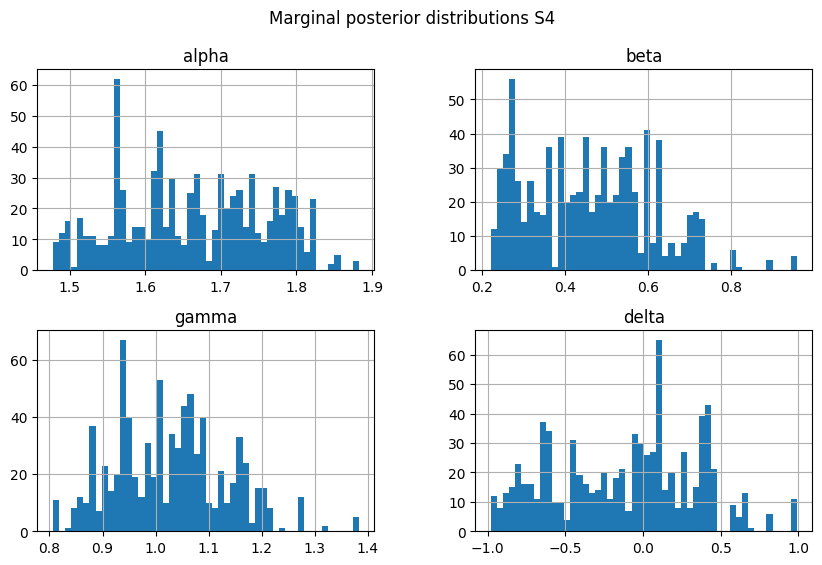

alpha  mean = 1.663,  95% CI = [1.493, 1.825]
beta   mean = 0.460,  95% CI = [0.242, 0.728]
gamma  mean = 1.027,  95% CI = [0.859, 1.214]
delta  mean = -0.119,  95% CI = [-0.897, 0.648]


In [203]:
import matplotlib.pyplot as plt
import seaborn as sns

#do some descriptive statistics 
df = pd.DataFrame(theta_posterior_s4, columns=["alpha", "beta", "gamma", "delta"])

df.hist(bins=50, figsize=(10, 6))
plt.suptitle("Marginal posterior distributions S4" )
plt.show()

mean = np.mean(theta_posterior_s4, axis=0)
ci95 = np.percentile(theta_posterior_s4, [2.5, 97.5], axis=0)

for name, m, ci in zip(["alpha", "beta", "gamma", "delta"], mean, ci95.T):
    print(f"{name:6s} mean = {m:.3f},  95% CI = [{ci[0]:.3f}, {ci[1]:.3f}]")



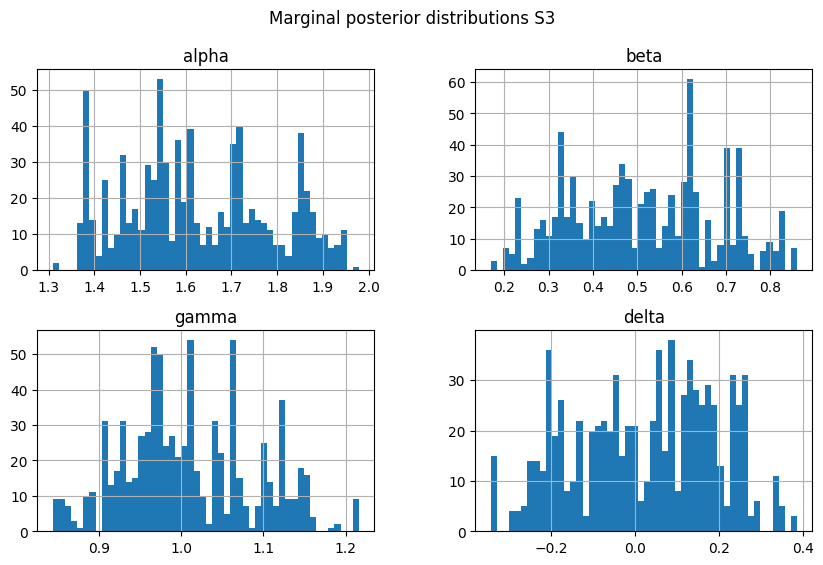

alpha  mean = 1.627,  95% CI = [1.382, 1.918]
beta   mean = 0.513,  95% CI = [0.231, 0.819]
gamma  mean = 1.009,  95% CI = [0.864, 1.156]
delta  mean = 0.024,  95% CI = [-0.280, 0.292]


In [204]:
import matplotlib.pyplot as plt
import seaborn as sns

#do some descriptive statistics 
df = pd.DataFrame(theta_posterior_s3, columns=["alpha", "beta", "gamma", "delta"])

df.hist(bins=50, figsize=(10, 6))
plt.suptitle("Marginal posterior distributions S3")
plt.show()

mean = np.mean(theta_posterior_s3, axis=0)
ci95 = np.percentile(theta_posterior_s3, [2.5, 97.5], axis=0)

for name, m, ci in zip(["alpha", "beta", "gamma", "delta"], mean, ci95.T):
    print(f"{name:6s} mean = {m:.3f},  95% CI = [{ci[0]:.3f}, {ci[1]:.3f}]")

